In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, auc, roc_curve

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_25.json")

merger_info = pd.read_json(r"../../../data/processed/merger_info_2023_03_25.json")

### Balance data and split to train and test set

In [4]:
label_name = "phase2"

In [5]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [6]:
len(df_test1_grouped)

40

In [7]:
df_test_grouped['case_num'][df_test_grouped['case_num'].duplicated()]

Series([], Name: case_num, dtype: object)

In [8]:
df_test_grouped[df_test_grouped['case_num']=="M.5020"]

,year,article_new,case_num,label,text_clean
422,2008,article6(2),M.5020,0,present transaction raise horizontal vertical ...


In [9]:
df_test1_grouped['case_num'][df_test1_grouped['case_num'].duplicated()]

Series([], Name: case_num, dtype: object)

In [10]:
df_train_grouped = pd.merge(df_train_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_test_grouped = pd.merge(df_test_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_test1_grouped = pd.merge(df_test1_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_excluded_grouped = pd.merge(df_excluded_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])

In [11]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [7]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (3,3)], # limit to trigrams
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [9]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=5, scoring='f1') #roc_auc

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
done in 6345.555s
Best cross-validation score:  0.9285604375231739
Best parameters set:
	clf__C: 0.1
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


In [8]:
# grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1') #roc_auc

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
done in 5034.406s
Best cross-validation score:  0.9593286580466068
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


##### Model fitting and evaluation

In [11]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=5)

fitting the best model
Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        79
           1       0.95      0.91      0.93        78

    accuracy                           0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157


CR: (0.930650406504065, 0.9298117494320026, 0.9298907968984695, None)

Confusion matrix:
 [[75  4]
 [ 7 71]] 

_______________________


 Accuracy: 92.994 
 Precision: 0.947 
 Recall: 0.910 
 F1: 0.928 
 FPR: 0.051 
 ROC_AUC: 0.930


In [15]:
evaluate(y_train, y_predict_cv)

Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        79
           1       0.95      0.91      0.93        78

    accuracy                           0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157


CR: (0.930650406504065, 0.9298117494320026, 0.9298907968984695, None)

Confusion matrix:
 [[75  4]
 [ 7 71]] 

_______________________


 Accuracy: 92.994 
 Precision: 0.947 
 Recall: 0.910 
 F1: 0.928 
 FPR: 0.051 
 ROC_AUC: 0.930


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [12]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full_p2.xlsx', index=True)
df_features_cv.head()

,feature,importance
491,car light,-0.152551
3414,prescription,-0.145527
621,commercial vehicle,-0.142814
1002,currently controlled,-0.132636
2528,italy united,0.129468


In [16]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9417952314165497

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1406
           1       0.16      0.75      0.27        20

    accuracy                           0.94      1426
   macro avg       0.58      0.85      0.62      1426
weighted avg       0.98      0.94      0.96      1426


CR: (0.5787696924231058, 0.8472617354196301, 0.6175918476803433, None)

Confusion matrix:
 [[1328   78]
 [   5   15]] 

_______________________


 Accuracy: 94.180 
 Precision: 0.161 
 Recall: 0.750 
 F1: 0.265 
 FPR: 0.055 
 ROC_AUC: 0.847


In [19]:
evaluate(y_test, y_predict_cv_test)

Accuracy: 0.9417952314165497

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1406
           1       0.16      0.75      0.27        20

    accuracy                           0.94      1426
   macro avg       0.58      0.85      0.62      1426
weighted avg       0.98      0.94      0.96      1426


CR: (0.5787696924231058, 0.8472617354196301, 0.6175918476803433, None)

Confusion matrix:
 [[1328   78]
 [   5   15]] 

_______________________


 Accuracy: 94.180 
 Precision: 0.161 
 Recall: 0.750 
 F1: 0.265 
 FPR: 0.055 
 ROC_AUC: 0.847


In [20]:
y_predict_cv_test1 = fit_best_model_test(X_test1, y_test1, pipeline_cv)

testing on test set
Accuracy: 0.8

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.83      0.75      0.79        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40


CR: (0.803030303030303, 0.8, 0.7994987468671679, None)

Confusion matrix:
 [[17  3]
 [ 5 15]] 

_______________________


 Accuracy: 80.000 
 Precision: 0.833 
 Recall: 0.750 
 F1: 0.789 
 FPR: 0.150 
 ROC_AUC: 0.800


### Model training (with 10-fold CV) using best parameters from GridSearch

In [21]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 0.1
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


In [12]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (1,2), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c = 0.1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [13]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.8662420382165605

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        79
           1       0.93      0.79      0.86        78

    accuracy                           0.87       157
   macro avg       0.87      0.87      0.87       157
weighted avg       0.87      0.87      0.87       157


CR: (0.8737976782752902, 0.8657903278156442, 0.8654560293817588, None)

Confusion matrix:
 [[74  5]
 [16 62]] 

_______________________


 Accuracy: 86.624 
 Precision: 0.925 
 Recall: 0.795 
 F1: 0.855 
 FPR: 0.063 
 ROC_AUC: 0.866


In [20]:
evaluate(y_train, y_predict_train)

Accuracy: 0.8662420382165605

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        79
           1       0.93      0.79      0.86        78

    accuracy                           0.87       157
   macro avg       0.87      0.87      0.87       157
weighted avg       0.87      0.87      0.87       157


CR: (0.8737976782752902, 0.8657903278156442, 0.8654560293817588, None)

Confusion matrix:
 [[74  5]
 [16 62]] 

_______________________


 Accuracy: 86.624 
 Precision: 0.925 
 Recall: 0.795 
 F1: 0.855 
 FPR: 0.063 
 ROC_AUC: 0.866


In [14]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9326788218793829

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1406
           1       0.15      0.80      0.25        20

    accuracy                           0.93      1426
   macro avg       0.57      0.87      0.61      1426
weighted avg       0.99      0.93      0.95      1426


CR: (0.5725566233912213, 0.8672830725462304, 0.6073788546255505, None)

Confusion matrix:
 [[1314   92]
 [   4   16]] 

_______________________


 Accuracy: 93.268 
 Precision: 0.148 
 Recall: 0.800 
 F1: 0.250 
 FPR: 0.065 
 ROC_AUC: 0.867


In [15]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.875

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.94      0.80      0.86        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40


CR: (0.8836317135549872, 0.875, 0.8742928975487115, None)

Confusion matrix:
 [[19  1]
 [ 4 16]] 

_______________________


 Accuracy: 87.500 
 Precision: 0.941 
 Recall: 0.800 
 F1: 0.865 
 FPR: 0.050 
 ROC_AUC: 0.875


### Confusion matrix and model performance

In [21]:
def eval_matrix(df, X, y_true, y_pred):
    results = pd.DataFrame(np.column_stack((X, y_true, y_pred)), columns=['text', 'target', 'y_predict'])
    results = pd.concat([df, results], axis=1)

    tn=results[(results.target == 0) & (results.y_predict == 0)]
    fp=results[(results.target == 0) & (results.y_predict == 1)]
    fn=results[(results.target == 1) & (results.y_predict == 0)]
    tp=results[(results.target == 1) & (results.y_predict == 1)]

    return (results, tn, fp, fn, tp)


In [22]:
results_train, tn, fp, fn, tp = eval_matrix(df_train_grouped, X_train, y_train, y_predict_train)

In [23]:
results1, tn, fp, fn, tp = eval_matrix(df_test1_grouped, X_test1, y_test1, y_predict_test1)

In [28]:
results2, tn, fp, fn, tp = eval_matrix(df_test_grouped, X_test, y_test, y_predict_test)

In [29]:
print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 1314
FP: 92
FN: 4
TP: 16


In [30]:
tn['nace_code'].value_counts().head(10)

Telecommunications                                                                                                    37
Manufacture of chemicals and chemical products                                                                        36
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                          36
Manufacture of other parts and accessories for motor vehicles                                                         24
Financial service activities, except insurance and pension funding                                                    18
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms    14
Computer programming, consultancy and related activities                                                              13
Manufacture of pharmaceutical preparations                                                                            12
Manufacture of medical and denta

In [31]:
fp['nace_code'].value_counts().head(10)

Freight air transport; Passenger air transport                                                                                                                      4
Telecommunications                                                                                                                                                  3
Financial service activities, except insurance and pension funding                                                                                                  2
Freight air transport; Passenger air transport; Service activities incidental to air transportation                                                                 2
Tour operator activities                                                                                                                                            2
Television programming and broadcasting activities; Wired telecommunications activities; Wireless telecommunications activities                                     2
Manu

In [32]:
fn['nace_code'].value_counts().head(10)

Warehousing and storage                                                                                                                                     1
Electric power generation, transmission and distribution; Manufacture of gas; distribution of gaseous fuels through mains                                   1
Manufacture of other products of wood; manufacture of articles of cork, straw and plaiting materials; Manufacture of veneer sheets and wood-based panels    1
Manufacture of railway locomotives and rolling stock                                                                                                        1
Name: nace_code, dtype: int64

In [33]:
tp['nace_code'].value_counts().head(10)

Printing and service activities related to printing                                                                                                                                                                                                                                                                                                                                                                                                         1
Computer programming, consultancy and related activities; Construction of residential and non-residential buildings; Construction of water projects; Electrical installation; Manufacture of electric motors, generators and transformers; Manufacture of electricity distribution and control apparatus; Manufacture of engines and turbines, except aircraft, vehicle and cycle engines; Manufacture of other electronic and electric wires and cables    1
Manufacture of other non-metallic mineral products n.e.c.                                                   

In [ ]:
#TODO: 
# define function to describe confusion matrix

### Feature importance

In [16]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
4309,spain germany,0.153824,0.153824
3006,oj eea,-0.139151,0.139151
2325,italy united,0.125015,0.125015
724,committee concentration,0.124372,0.124372
61,active generation,-0.121386,0.121386
450,budget business,-0.121312,0.121312
3983,retailing,-0.120567,0.120567
2337,jv para,-0.120202,0.120202
1546,energy company,-0.116309,0.116309
3823,regard right,0.112121,0.112121


In [17]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [18]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

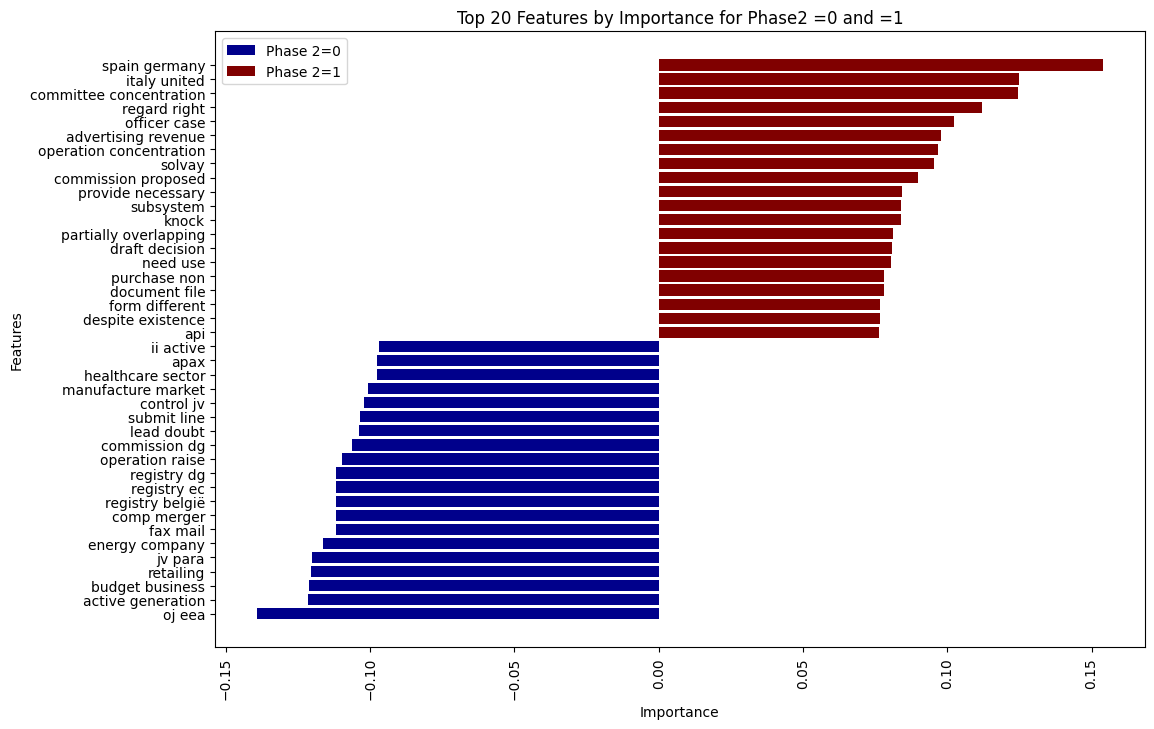

In [19]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [36]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_p2.xlsx', index=True)